In [426]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import IPython.display as ipd
import import_ipynb
from pathlib import Path
from AF1 import hashData, A

from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import (generate_binary_structure,
                                   binary_erosion)
from scipy.ndimage.morphology import iterate_structure
from operator import xor   

sampling_rate = 22050

C:\Users\Narwh\AppData\Local\Temp\ipykernel_6620\3472380940.py:11: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter
C:\Users\Narwh\AppData\Local\Temp\ipykernel_6620\3472380940.py:12: DeprecationWarning: Please use `generate_binary_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import (generate_binary_structure,
C:\Users\Narwh\AppData\Local\Temp\ipykernel_6620\3472380940.py:12: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import (generate_binary_structure,
C:\Users\Narwh\AppData\Local\Temp\ipykernel_6620\3472380940.py:14: DeprecationWarning: Please use `iterate_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` n

# Load and plot audio file in test directory

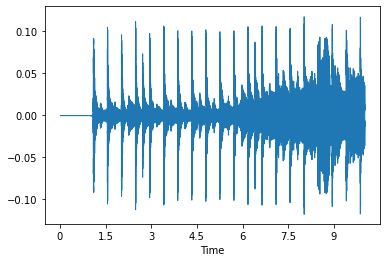

In [427]:
pathAudio = "AudioTest/"
files = librosa.util.find_files(pathAudio, ext=['wav']) 
files = np.asarray(files)
data, sr = librosa.load(files[0])
librosa.display.waveshow(data, sr=sr)

# Compute STFT of Target Audio File

In [428]:
specgram, freqs, times = mlab.specgram(data, NFFT=4096, Fs=sampling_rate, noverlap=int(4096 / 2))
specgram[specgram == 0] = 1e-6

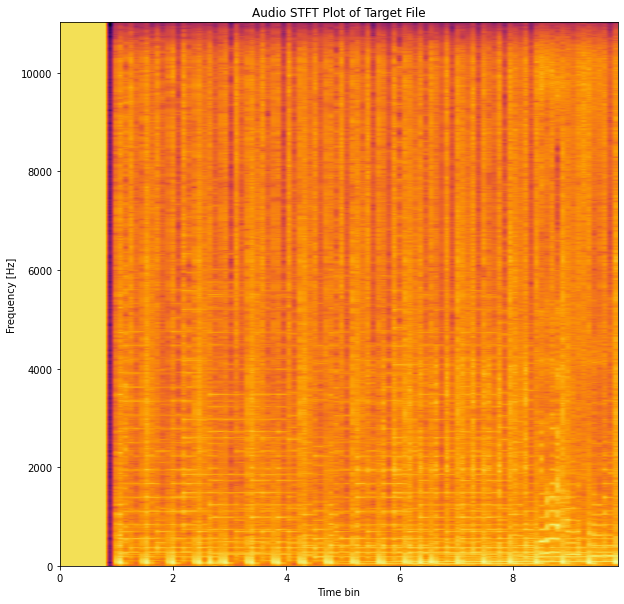

(2049, 106)

In [429]:
fig1 = plt.figure(figsize=(10, 10), facecolor='white')
extent = 0, np.amax(times), freqs[0], freqs[-1] #data coord of bounding box

Z = 10.0 * np.log10(specgram)
Z = np.flipud(Z)

plt.imshow(Z, cmap='inferno', extent=extent)
plt.xlabel('Time bin')
plt.ylabel('Frequency [Hz]')
plt.title('Audio STFT Plot of Target File')
plt.axis('auto')

ax = plt.gca() #get current axes
ax.set_xlim([0, extent[1]])
ax.set_ylim([freqs[0], freqs[-1]])

plt.show()

Z.shape

# Grab Peaks for Target Audio File

In [430]:
# Get 90% cutoff threshold
def find_90_C_k(spec_gram):
    spec_gram = spec_gram[spec_gram != 0] #remove 0's
    specgram_flattened = spec_gram.flatten() #returns copy of orig
    specgram_sorted = np.sort(np.log(np.abs(specgram_flattened)))
    specgram_length = len(specgram_sorted)
    
    ninety_index = int(0.9 * specgram_length)
    ninety_C_k = specgram_sorted[ninety_index]
    return ninety_C_k

In [431]:
def spectogram_to_peaks(specgram, freqs, times):
    fp = generate_binary_structure(2, 1)
    fp = iterate_structure(fp, 20)
    background_threshold = find_90_C_k(specgram)
    peaks = ((specgram == maximum_filter(specgram, footprint = fp)) & (specgram > background_threshold))
    return peaks

In [432]:
peaks_array = spectogram_to_peaks(specgram, freqs, times)
peaks_where = np.where(peaks_array)
y_freq = peaks_where[0]
x_frame = peaks_where[1]

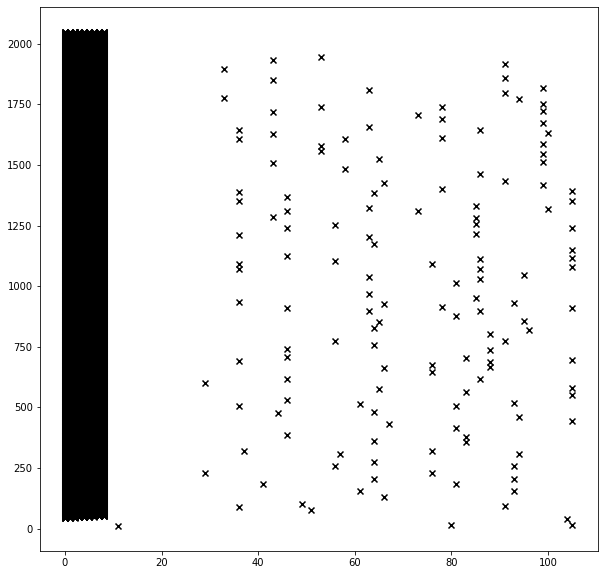

In [433]:
fig2 = plt.figure(figsize=(10, 10), facecolor='white')
plt.scatter(x_frame, y_freq, marker='x', color='black')
plt.show()

# Hash Generation for Target File


In [434]:
import hashlib

def create_fingerprints(peaks):
    hashes = []
    for i in range(len(peaks)):
        for j in range(1, 15):
            if (i + j) < len(peaks):
                t1 = peaks[i][0]
                t2 = peaks[i + j][0]
                freq1 = peaks[i][1]
                freq2 = peaks[i + j][1]
                delta = t2 - t1

                hash = hashlib.sha1(str(str(freq1) + str(freq2) + str(delta)).encode('utf-8'))

                hashes.append((hash.hexdigest(), t1))

    return hashes

# Hash List to Compare

In [435]:
peaksList = list(zip(x_frame, y_freq))
taf = create_fingerprints(peaksList)
taf

[('e7a2da628f8982eb3ec8c356d9b56fa34cfef6cf', 11),
 ('191b80858f7f8100bfe0934281817d072042946d', 11),
 ('a3813ac43e2875169b7d76ae969b696f6da4c312', 11),
 ('72e9257c3f95080234270650e9a4c0e11c3da45c', 11),
 ('80099159037a1152e81e4943daf6abd1d15edae6', 11),
 ('cefa118b6fe33d4025823ed6fab56e73764272a5', 11),
 ('dae28e1880c16935a876904b1b73570ae17a1802', 11),
 ('a514490648689986cf764c321606aabd62735f6b', 11),
 ('74a14964f219f5c8bdf551b3f7f980e3d84d60ef', 11),
 ('e919e36a6994b5bfd8fc2b7a028eeeb3aa124219', 11),
 ('d33c1dbd9c7edb5e27257c83e0cd37d3eede809d', 11),
 ('661003dc14f5d634c7ae932e2757b1c914259104', 11),
 ('0ad74a94ca25fcbddf101fcb2825967a151955ee', 11),
 ('01c806b2e09009180c1c7bfd97772621a39049a2', 11),
 ('bc32be694349ab428a42061cc810eaaa423cf7b8', 80),
 ('5a361eb67bd8186b0e77e64d11dc7079d4350ea6', 80),
 ('d577ce404c3f09f37546ee043eb67a8cc2ad7b22', 80),
 ('b92de86a0edb30042355190447a61def22e3641f', 80),
 ('f39e75b6311d535d6f17e680cb01a4c50ed31197', 80),
 ('e34293f55b0c859bee33550422d5

In [436]:
sameFrequencyPercentage = []
def fingerprint_distance(
    f1: list[int],
    f2: list[int],
    fingerprint_len: int,
) -> float:
    """
    Returns a normalized distance between two fingerprints.

    Args:
        f1: The first fingerprint.

        f2: The second fingerprint.

        fingerprint_len: Only compare the first `fingerprint_len`
            integers in each fingerprint. This is useful
            when comparing audio samples of a different length.

    Returns:
        Returns a number between 0.0 and 1.0 representing
        the distance between two fingerprints. This value
        represents distance as like a percentage.
    """
    max_hamming_weight = 32 * fingerprint_len
    hamming_weight = sum(
        sum(
            c == "1"
            for c in bin(f1[i][0][0] != f2[i][0][0])

        )
        for i in range(fingerprint_len)
    )
    print(hamming_weight)
    sameFrequencyPercentage.append(hamming_weight)
    return hamming_weight / max_hamming_weight

In [437]:
for i in hashData:
    f_len = min(len(hashData[i]), len(taf))
    fingerprint_distance(hashData[i], taf, f_len)

51308
104575
74309
86660
237757


In [438]:
max_value = max(sameFrequencyPercentage)
max_index = sameFrequencyPercentage.index(max_value)
songName = A[max_index]
print('The song is '+ Path(songName).stem)

The song is Taylor Swift - You Belong With Me
